# AutoML

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/205-automl.ipynb)

This notebooks covers AutoML utilities of ETNA library.

**Table of contents**

- [Hyperparameters tuning](#chapter_1)
    - [How Tune works](#section_1_1)
    - [Example](#section_1_2)
- [General AutoML](#chapter_2)
    - [How Auto works](#section_2_1)
    - [Example](#section_2_2)
    - [Using custom pipeline pool](#section_2_3)
- [Summary](chapter_3)

In [1]:
!pip install "etna[auto, prophet]" -q

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd

from etna.datasets import TSDataset
from etna.metrics import SMAPE
from etna.models import LinearPerSegmentModel
from etna.models import NaiveModel
from etna.models import ProphetModel
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform

In [4]:
HORIZON = 14

## 1. Hyperparameters tuning <a class="anchor" id="chapter_1"></a>

It is a common task to tune hyperparameters of existing pipeline to improve its quality. For this purpose there is an `etna.auto.Tune` class, which is responsible for creating [optuna](https://github.com/optuna/optuna) study to solve this problem.

In the next sections we will see how it works and how to use it for your particular problems.

### 1.1 How `Tune` works <a class="anchor" id="section_1_1"></a>

During init `Tune` accepts `pipeline`, its tuning parameters (`params_to_tune`), optimization metric (`target_metric`), parameters of backtest and parameters of optuna study.

In `fit` the optuna study is created. During each trial the sample of parameters is generated from `params_to_tune` and applied to `pipeline`. After that, the new pipeline is checked in backtest and target metric is returned to optuna framework.

Let's look closer at `params_to_tune` parameter. It expects dictionary with parameter names and its distributions. But how this parameter names should be chosen?

#### 1.1.1 `set_params`

We are going to make a little detour to explain the `set_params` method, which is supported by ETNA pipelines, models and transforms. Given a dictionary with parameters it allows to create from existing object a new one with changed parameters.

First, we define some objects for our future examples.

In [5]:
model = LinearPerSegmentModel()
transforms = [
    LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON + 10)), out_column="target_lag"),
    DateFlagsTransform(out_column="date_flags"),
]
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

Let's look at simple example, when we want to change `fit_intercept` parameter of the `model`.

In [6]:
model.to_dict()

{'fit_intercept': True,
 'kwargs': {},
 '_target_': 'etna.models.linear.LinearPerSegmentModel'}

In [7]:
new_model_params = {"fit_intercept": False}
new_model = model.set_params(**new_model_params)
new_model.to_dict()

{'fit_intercept': False,
 'kwargs': {},
 '_target_': 'etna.models.linear.LinearPerSegmentModel'}

Great! On the next step we want to change the `fit_intercept` of `model` inside the `pipeline`.

In [8]:
pipeline.to_dict()

{'model': {'fit_intercept': True,
  'kwargs': {},
  '_target_': 'etna.models.linear.LinearPerSegmentModel'},
 'transforms': [{'in_column': 'target',
   'lags': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
   'out_column': 'target_lag',
   '_target_': 'etna.transforms.math.lags.LagTransform'},
  {'day_number_in_week': True,
   'day_number_in_month': True,
   'day_number_in_year': False,
   'week_number_in_month': False,
   'week_number_in_year': False,
   'month_number_in_year': False,
   'season_number': False,
   'year_number': False,
   'is_weekend': True,
   'special_days_in_week': (),
   'special_days_in_month': (),
   'out_column': 'date_flags',
   '_target_': 'etna.transforms.timestamp.date_flags.DateFlagsTransform'}],
 'horizon': 14,
 '_target_': 'etna.pipeline.pipeline.Pipeline'}

In [9]:
new_pipeline_params = {"model.fit_intercept": False}
new_pipeline = pipeline.set_params(**new_pipeline_params)
new_pipeline.to_dict()

{'model': {'fit_intercept': False,
  'kwargs': {},
  '_target_': 'etna.models.linear.LinearPerSegmentModel'},
 'transforms': [{'in_column': 'target',
   'lags': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
   'out_column': 'target_lag',
   '_target_': 'etna.transforms.math.lags.LagTransform'},
  {'day_number_in_week': True,
   'day_number_in_month': True,
   'day_number_in_year': False,
   'week_number_in_month': False,
   'week_number_in_year': False,
   'month_number_in_year': False,
   'season_number': False,
   'year_number': False,
   'is_weekend': True,
   'special_days_in_week': (),
   'special_days_in_month': (),
   'out_column': 'date_flags',
   '_target_': 'etna.transforms.timestamp.date_flags.DateFlagsTransform'}],
 'horizon': 14,
 '_target_': 'etna.pipeline.pipeline.Pipeline'}

Ok, it looks like we managed to do this. On the last step we are going to change `is_weekend` flag of `DateFlagsTransform` inside our `pipeline`.

In [10]:
new_pipeline_params = {"transforms.1.is_weekend": False}
new_pipeline = pipeline.set_params(**new_pipeline_params)
new_pipeline.to_dict()

{'model': {'fit_intercept': True,
  'kwargs': {},
  '_target_': 'etna.models.linear.LinearPerSegmentModel'},
 'transforms': [{'in_column': 'target',
   'lags': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
   'out_column': 'target_lag',
   '_target_': 'etna.transforms.math.lags.LagTransform'},
  {'day_number_in_week': True,
   'day_number_in_month': True,
   'day_number_in_year': False,
   'week_number_in_month': False,
   'week_number_in_year': False,
   'month_number_in_year': False,
   'season_number': False,
   'year_number': False,
   'is_weekend': False,
   'special_days_in_week': (),
   'special_days_in_month': (),
   'out_column': 'date_flags',
   '_target_': 'etna.transforms.timestamp.date_flags.DateFlagsTransform'}],
 'horizon': 14,
 '_target_': 'etna.pipeline.pipeline.Pipeline'}

As we can see, we managed to do this.

#### 1.1.2 `params_to_tune`

Let's get back to our initial question about `params_to_tune`. In our optuna study we are going to sample each parameter value from its distribution and pass it into `pipeline.set_params` method. So, the keys for `params_to_tune` should be a valid for `set_params` method.

Distributions are taken from `etna.distributions` and they are matching `optuna.Trial.suggest_` methods.

For example, something like this will be valid for our `pipeline` defined above:

In [11]:
from etna.distributions import CategoricalDistribution

example_params_to_tune = {
    "model.fit_intercept": CategoricalDistribution(choices=[False, True]),
    "transforms.1.is_weekend": CategoricalDistribution(choices=[False, True]),
}

This custom dict could be passed into `Tune` class. This will be shown in the [Example](#custom_params) below.

There are some good news: it isn't necessary for our users to define `params_to_tune`, because we have a default grid for many of our classes. The default grid is available by calling `params_to_tune` method on pipeline, model or transform. Let's check our `pipeline`:

In [12]:
pipeline.params_to_tune()

{'model.fit_intercept': CategoricalDistribution(choices=[False, True]),
 'transforms.1.day_number_in_week': CategoricalDistribution(choices=[False, True]),
 'transforms.1.day_number_in_month': CategoricalDistribution(choices=[False, True]),
 'transforms.1.day_number_in_year': CategoricalDistribution(choices=[False, True]),
 'transforms.1.week_number_in_month': CategoricalDistribution(choices=[False, True]),
 'transforms.1.week_number_in_year': CategoricalDistribution(choices=[False, True]),
 'transforms.1.month_number_in_year': CategoricalDistribution(choices=[False, True]),
 'transforms.1.season_number': CategoricalDistribution(choices=[False, True]),
 'transforms.1.year_number': CategoricalDistribution(choices=[False, True]),
 'transforms.1.is_weekend': CategoricalDistribution(choices=[False, True])}

Now we are ready to use it in practice.

### 1.2 Example <a class="anchor" id="section_1_2"></a>

#### 1.2.1 Loading data

Let's start by loading example data.

In [13]:
df = pd.read_csv("data/example_dataset.csv")
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


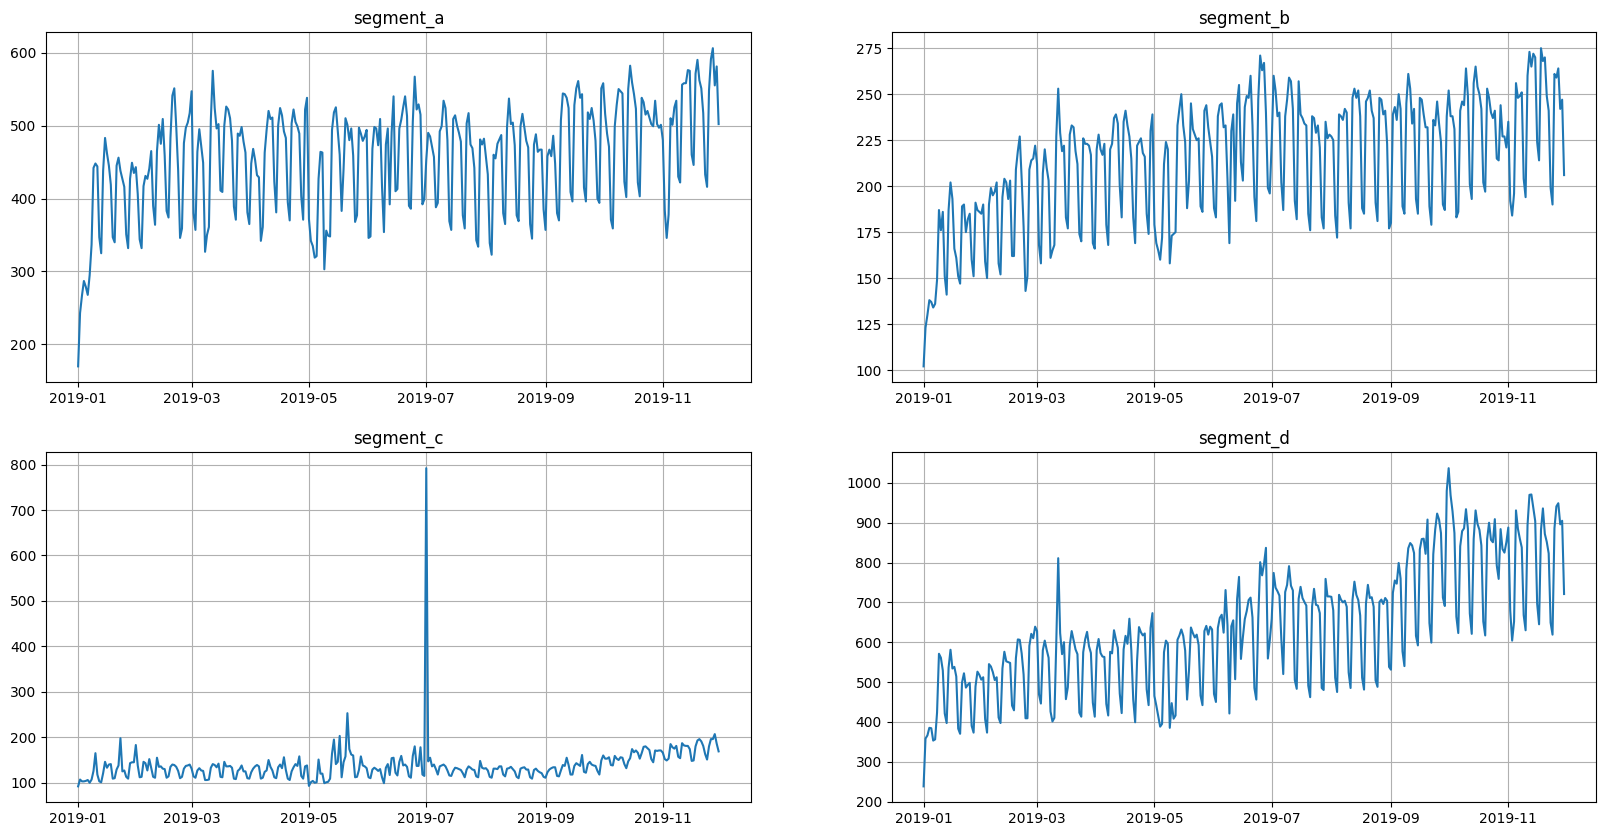

In [14]:
full_ts = TSDataset(df, freq="D")
full_ts.plot()

Let's divide current dataset into train and validation parts. We will use validation part later to check final results.

In [15]:
ts, _ = full_ts.train_test_split(test_size=HORIZON * 5)

#### 1.2.2 Running `Tune`

We are going to define our `Tune` object:

In [16]:
from etna.auto import Tune

tune = Tune(pipeline=pipeline, target_metric=SMAPE(), horizon=HORIZON, backtest_params=dict(n_folds=5))

We used mostly default parameters for this example. But for your own experiments you might want to also set up other parameters. 

For example, parameter `runner` allows you to run tuning in parallel on a local machine, and parameter `storage` makes it possible to store optuna results on a dedicated remote server.

For a full list of parameters we advise you to check our documentation.

Let's hide the logs of optuna, there are too many of them for a notebook.

In [17]:
import optuna

optuna.logging.set_verbosity(optuna.logging.CRITICAL)

Let's run the tuning

In [18]:
%%capture
best_pipeline = tune.fit(ts=ts, n_trials=20)

Command `%%capture` just hides the output.

#### 1.2.3 Running `Tune` with custom `params_to_tune`<a class="anchor" id="custom_params"></a>

Let's remember that earlier we created a dict:
```python
example_params_to_tune = {
    "model.fit_intercept": CategoricalDistribution(choices=[False, True]),
    "transforms.1.is_weekend": CategoricalDistribution(choices=[False, True]),
}
```
Now we can use these parameters when initializing `Tune`.

In [19]:
tune_custom_params = Tune(
    pipeline=pipeline,
    target_metric=SMAPE(),
    horizon=HORIZON,
    backtest_params=dict(n_folds=5),
    params_to_tune=example_params_to_tune,
)

Let's run the tuning with our custom parameters.

In [20]:
%%capture
best_pipeline_custom_params = tune_custom_params.fit(ts=ts, n_trials=20)

#### 1.2.4 Analysis

In the last section dedicated to `Tune` we will look at methods for result analysis.

First of all there is `summary` method that shows us the results of optuna trials.

In [21]:
tune.summary()

,MAE_mean,MAE_median,MAE_notna_size,MAE_percentile_25,MAE_percentile_5,MAE_percentile_75,MAE_percentile_95,MAE_std,MSE_mean,MSE_median,...,Sign_notna_size,Sign_percentile_25,Sign_percentile_5,Sign_percentile_75,Sign_percentile_95,Sign_std,elapsed_time,hash,pipeline,state
0,25.667904,26.788472,4.0,20.385243,15.145294,32.071133,34.621717,8.217865,1527.813269,1356.477027,...,4.0,-0.621429,-0.672857,-0.357143,-0.254286,0.177712,1.586009,f4f02e1d5f60b8f322a4a8a622dd1c1e,Pipeline(model = LinearPerSegmentModel(fit_int...,1
1,26.606482,28.272429,4.0,20.554262,15.198315,34.324649,35.682322,8.900725,1729.295705,1599.030615,...,4.0,-0.642857,-0.745714,-0.300000,-0.265714,0.209956,1.700775,3d7b7af16d71a36f3b935f69e113e22d,Pipeline(model = LinearPerSegmentModel(fit_int...,1
2,26.427670,26.809357,4.0,20.238589,11.884902,32.998438,40.436078,11.702270,2133.343967,1997.594638,...,4.0,-0.392857,-0.581429,-0.078571,-0.061429,0.229017,1.096877,7c7932114268832a5458acfecfb453fc,Pipeline(model = LinearPerSegmentModel(fit_int...,1
3,34.586733,35.616831,4.0,29.797233,16.157674,40.406330,51.573653,14.750408,3185.461093,3324.924980,...,4.0,-0.100000,-0.340000,0.014286,0.048571,0.182946,0.989273,b7ac5f7fcf9c8959626befe263a9d561,Pipeline(model = LinearPerSegmentModel(fit_int...,1
4,28.046631,28.279612,4.0,22.153130,14.349408,34.173114,41.417681,11.090567,1875.958439,2045.887754,...,4.0,-0.585714,-0.620000,-0.250000,-0.232857,0.179994,0.785666,e928929f89156d88ef49e28abaf55847,Pipeline(model = LinearPerSegmentModel(fit_int...,1
5,31.714578,34.650441,4.0,25.441858,14.662179,40.923160,44.656767,12.690827,2496.862613,2344.530581,...,4.0,-0.514286,-0.788571,-0.271429,0.037143,0.343749,1.141506,3b4311d41fcaab7307235ea23b6d4599,Pipeline(model = LinearPerSegmentModel(fit_int...,1
6,28.401011,30.937439,4.0,22.517391,15.064969,36.821059,38.186053,10.036415,2160.703619,1565.256313,...,4.0,-0.621429,-0.672857,-0.257143,-0.188571,0.213212,0.849209,74065ebc11c81bed6a9819d026c7cd84,Pipeline(model = LinearPerSegmentModel(fit_int...,1
7,28.834402,30.782735,4.0,23.540480,15.883965,36.076656,39.057173,9.768319,1887.330868,1671.590780,...,4.0,-0.657143,-0.725714,-0.250000,-0.232857,0.225312,0.883154,b0d0420255c6117045f8254bf8f377a0,Pipeline(model = LinearPerSegmentModel(fit_int...,1
8,27.589468,28.296973,4.0,21.668623,14.025183,34.217818,40.163245,10.745756,1861.965363,2038.946807,...,4.0,-0.671429,-0.705714,-0.242857,-0.208571,0.230350,0.875966,25dcd8bb095f87a1ffc499fa6a83ef5d,Pipeline(model = LinearPerSegmentModel(fit_int...,1
9,29.720151,28.713470,4.0,23.395341,14.726153,35.038280,46.123501,12.942420,1975.650004,1963.591771,...,4.0,-0.657143,-0.725714,-0.192857,-0.175714,0.253446,1.043901,3f1ca1759261598081fa3bb2f32fe0ac,Pipeline(model = LinearPerSegmentModel(fit_int...,1


Let's show only the columns we are interested in.

In [22]:
tune.summary()[["hash", "pipeline", "SMAPE_mean", "elapsed_time", "state"]].sort_values("SMAPE_mean")

,hash,pipeline,SMAPE_mean,elapsed_time,state
19,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,1.131200,1
17,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,1.131200,1
16,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,1.131200,1
15,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,1.131200,1
14,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,1.131200,1
13,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,1.131200,1
12,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,1.131200,1
10,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,1.131200,1
11,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,1.131200,1
2,7c7932114268832a5458acfecfb453fc,Pipeline(model = LinearPerSegmentModel(fit_int...,9.210183,1.096877,1


As we can see, we have duplicate lines according to the `hash` column. Some trials have the same sampled hyperparameters and they have the same results. We have a special handling for such duplicates: they are skipped during optimization and the previously computed metric values are returned.

Duplicates on the summary can be eliminated using `hash` column.

In [23]:
tune.summary()[["hash", "pipeline", "SMAPE_mean", "elapsed_time", "state"]].sort_values("SMAPE_mean").drop_duplicates(
    subset="hash"
)

,hash,pipeline,SMAPE_mean,elapsed_time,state
19,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,1.131200,1
2,7c7932114268832a5458acfecfb453fc,Pipeline(model = LinearPerSegmentModel(fit_int...,9.210183,1.096877,1
8,25dcd8bb095f87a1ffc499fa6a83ef5d,Pipeline(model = LinearPerSegmentModel(fit_int...,9.943658,0.875966,1
4,e928929f89156d88ef49e28abaf55847,Pipeline(model = LinearPerSegmentModel(fit_int...,9.946866,0.785666,1
0,f4f02e1d5f60b8f322a4a8a622dd1c1e,Pipeline(model = LinearPerSegmentModel(fit_int...,9.957781,1.586009,1
18,6f595f4f43b323804c04d4cea49c169b,Pipeline(model = LinearPerSegmentModel(fit_int...,10.061742,1.071287,1
1,3d7b7af16d71a36f3b935f69e113e22d,Pipeline(model = LinearPerSegmentModel(fit_int...,10.306909,1.700775,1
9,3f1ca1759261598081fa3bb2f32fe0ac,Pipeline(model = LinearPerSegmentModel(fit_int...,10.554444,1.043901,1
5,3b4311d41fcaab7307235ea23b6d4599,Pipeline(model = LinearPerSegmentModel(fit_int...,10.756703,1.141506,1
6,74065ebc11c81bed6a9819d026c7cd84,Pipeline(model = LinearPerSegmentModel(fit_int...,10.917164,0.849209,1


The second method `top_k` is useful when you want to check out best tried pipelines without duplicates.

In [24]:
top_3_pipelines = tune.top_k(k=3)

In [25]:
top_3_pipelines

[Pipeline(model = LinearPerSegmentModel(fit_intercept = True, ), transforms = [LagTransform(in_column = 'target', lags = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23], out_column = 'target_lag', ), DateFlagsTransform(day_number_in_week = False, day_number_in_month = True, day_number_in_year = False, week_number_in_month = True, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = 'date_flags', in_column = None, )], horizon = 14, ),
 Pipeline(model = LinearPerSegmentModel(fit_intercept = True, ), transforms = [LagTransform(in_column = 'target', lags = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23], out_column = 'target_lag', ), DateFlagsTransform(day_number_in_week = False, day_number_in_month = True, day_number_in_year = False, week_number_in_month = True, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_w

## 2. General AutoML <a class="anchor" id="chapter_2"></a>

Hyperparameters tuning is useful, but can be too narrow. In this section we move our attention to general AutoML pipeline.
In ETNA we have an `etna.auto.Auto` class for making automatic pipeline selection. It can be useful to quickly create a good baseline for your forecasting task.

### 2.1 How `Auto` works <a class="anchor" id="section_2_1"></a>

`Auto` init has similar parameters to `Tune`, but instead of `pipeline` it works with `pool`. Pool, in general, is just a list of pipelines.

During `fit` there are two stages:

- pool stage,
- tuning stage.

Pool stage is responsible for checking every pipeline suggested in a given `pool`. For each pipeline we run a backtest and compute `target_metric`. Results are saved in optuna study.

Tuning stage takes `tune_size` best pipelines according to the results of the pool stage. And then runs `Tune` with default `params_to_tune` for them sequentially from best to the worst.

Limit parameters `n_trials` and `timeout` are shared between pool and tuning stages. First, we run pool stage with given `n_trials` and `timeout`. After that, the remaining values are divided equally among `tune_size` tuning steps.

### 2.2 Example <a class="anchor" id="section_2_2"></a>

We will move straight to the example.

We have prepared pools for different frequencies and with different duration time. Frequency of our dataset is `D`, so we can choose `D_super_fast` pool. See docs of `Pool` class to know how to choose prepared pools correctly.

In [26]:
from etna.auto import Auto
from etna.auto import Pool

auto = Auto(
    target_metric=SMAPE(), horizon=HORIZON, pool=Pool.D_super_fast, generate_params={}, backtest_params=dict(n_folds=1)
)

Let's have a closer look at `generate_params`. It helps to set dynamic parameters for pipelines. Default pools contain `timestamp_column`, `chronos_device` and `timesfm_device` parameters.

Parameter `timestamp_column` can be met in some models and transform (e.g. `statsforecast` models or `DateFlagTransform`) and defines column with timestamps. We use such columns in misaligned datasets (see `307-working_with_misaligned_data` notebook).

- If you have regular `TSDataset` with `freq` != `None`, set `generate_params={}` or `generate_params=None`
- If you have `TSDataset` with int index and exogenous column (e.g.`external_timestamp`) with timestamps, set `generate_params={"timestamp_column": "external_timestamp"}`

Parameters `chronos_device` and `timesfm_device` specify `device` parameters for corresponding pretrained model. By default `Chronos`-like models use `device="auto"` and `TimesFMModel` use `device="gpu"`. As all models are initialized together, to reduce workload on gpu you can change device for one model type setting `generate_params={"timesfm_device": "cpu"}`

After initialization `Auto` you can see pipelines which will be fitted.

In [27]:
auto.get_configs()

[{'model': {'lag': 1, '_target_': 'etna.models.naive.NaiveModel'},
  'transforms': [],
  'horizon': 14,
  '_target_': 'etna.pipeline.pipeline.Pipeline'},
 {'model': {'lag': 7, '_target_': 'etna.models.naive.NaiveModel'},
  'transforms': [],
  'horizon': 14,
  '_target_': 'etna.pipeline.pipeline.Pipeline'},
 {'model': {'lag': 14, '_target_': 'etna.models.naive.NaiveModel'},
  'transforms': [],
  'horizon': 14,
  '_target_': 'etna.pipeline.pipeline.Pipeline'},
 {'model': {'window': 3,
   'seasonality': 7,
   '_target_': 'etna.models.seasonal_ma.SeasonalMovingAverageModel'},
  'transforms': [{'in_column': 'target',
    'strategy': 'forward_fill',
    'window': -1,
    'seasonality': 1,
    'constant_value': 0,
    '_target_': 'etna.transforms.missing_values.imputation.TimeSeriesImputerTransform'},
   {'in_column': 'target',
    'window_size': 21,
    'distance_coef': 3,
    'n_neighbors': 3,
    'distance_func': 'absolute_difference',
    '_target_': 'etna.transforms.outliers.point_outlie

Let's start the fitting. We can start by running only pool stage.

In [28]:
%%capture
best_pool_pipeline = auto.fit(ts=ts, tune_size=0)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [29]:
auto.summary()[["hash", "pipeline", "SMAPE_mean", "elapsed_time", "state", "study"]].sort_values("SMAPE_mean")

,hash,pipeline,SMAPE_mean,elapsed_time,state,study
8,5545ff3ef3cb3b2fc879b100afd9ca30,Pipeline(model = ChronosBoltModel(path_or_url ...,7.897397,0.446171,1,pool
3,d8215d95e2c6c9a4b4fdacf3fa77dddc,"Pipeline(model = NaiveModel(lag = 7, ), transf...",8.266340,0.035717,1,pool
6,8b532534025945b07dedac76ad1e6207,Pipeline(model = ChronosBoltModel(path_or_url ...,8.512619,0.419310,1,pool
0,07fbe9c7aeaf9f56701630c5897db4f2,Pipeline(model = SeasonalMovingAverageModel(wi...,9.134800,0.120682,1,pool
7,add1079869e9d79f001e8c2df6c64279,VotingEnsemble(pipelines = [Pipeline(model = S...,9.351593,0.075331,1,pool
2,7899a017183d4dc042a70d5b38e7ed96,Pipeline(model = ChronosBoltModel(path_or_url ...,9.369298,1.402410,1,pool
1,8b47488c737903536374d375f7c66f40,"Pipeline(model = NaiveModel(lag = 14, ), trans...",9.580548,0.046769,1,pool
4,de05e6c98895bc7d9c54fefe8dedea7b,Pipeline(model = DeadlineMovingAverageModel(wi...,14.151098,0.142992,1,pool
5,53e90ae4cf7f1f71e6396107549c25ef,"Pipeline(model = NaiveModel(lag = 1, ), transf...",22.155640,0.033679,1,pool


In [30]:
%%capture
best_pool_metrics = best_pool_pipeline.backtest(ts=full_ts, metrics=[SMAPE()], n_folds=5)["metrics"]

In [31]:
best_pool_smape = best_pool_metrics["SMAPE"].mean()
print(f"Best pool SMAPE: {best_pool_smape:.3f}")

Best pool SMAPE: 5.691


### 2.3 Using custom pipeline pool <a class="anchor" id="section_2_3"></a>

We can define our own set of pipelines for the search.

In [32]:
custom_pool = [
    Pipeline(model=NaiveModel(lag=1), transforms=(), horizon=HORIZON),
    Pipeline(
        model=LinearPerSegmentModel(),
        transforms=[LagTransform(in_column="target", lags=list(range(HORIZON, 2 * HORIZON)), out_column="target_lag")],
        horizon=HORIZON,
    ),
    Pipeline(
        model=ProphetModel(),
        transforms=[],
        horizon=HORIZON,
    ),
]

In [33]:
%%capture
custom_auto = Auto(
    target_metric=SMAPE(),
    horizon=HORIZON,
    pool=custom_pool,
    backtest_params=dict(n_folds=1),
    storage="sqlite:///etna-auto-custom.db",
)
best_custom_pool_pipeline = custom_auto.fit(ts=ts, tune_size=0)

In [34]:
custom_auto.summary()[["hash", "pipeline", "SMAPE_mean", "elapsed_time", "state", "study"]].sort_values("SMAPE_mean")

,hash,pipeline,SMAPE_mean,elapsed_time,state,study
1,6e2eb71d033b6d0607f5b6d0a7596ce9,Pipeline(model = ProphetModel(growth = 'linear...,7.784737,0.652359,1,pool
0,d4b50dc4c1b7debb0355ebfbd9c39ffb,Pipeline(model = LinearPerSegmentModel(fit_int...,8.587004,0.156382,1,pool
2,53e90ae4cf7f1f71e6396107549c25ef,"Pipeline(model = NaiveModel(lag = 1, ), transf...",22.155640,0.034337,1,pool


We can continue our training. The pool stage is over and there will be only the tuning stage. If we don't want to wait forever we should limit the tuning by fixing `n_trials` or `timeout`. 

We also set some parameters for `optuna.Study.optimize`: 

- `gc_after_trial=True`: to prevent `fit` from increasing memory consumption
- `catch=(Exception,)`: to prevent failing if some trials are erroneous.

In [35]:
%%capture
best_custom_tuning_pipeline = custom_auto.fit(ts=ts, tune_size=2, n_trials=10, gc_after_trial=True, catch=(Exception,))

Let's look at the results.

In [36]:
custom_auto.summary()[["hash", "pipeline", "SMAPE_mean", "elapsed_time", "state", "study"]].sort_values(
    "SMAPE_mean"
).drop_duplicates(subset=("hash", "study"))

,hash,pipeline,SMAPE_mean,elapsed_time,state,study
8,0da73fb28ad659adcd67e73d6a12ffcb,Pipeline(model = ProphetModel(growth = 'linear...,6.350313,0.681777,1,tuning/6e2eb71d033b6d0607f5b6d0a7596ce9
7,06056568d43cc286f099fd767f9c4e01,Pipeline(model = ProphetModel(growth = 'linear...,6.827116,0.946632,1,tuning/6e2eb71d033b6d0607f5b6d0a7596ce9
1,6e2eb71d033b6d0607f5b6d0a7596ce9,Pipeline(model = ProphetModel(growth = 'linear...,7.784737,0.652359,1,pool
0,d4b50dc4c1b7debb0355ebfbd9c39ffb,Pipeline(model = LinearPerSegmentModel(fit_int...,8.587004,0.156382,1,pool
4,d4b50dc4c1b7debb0355ebfbd9c39ffb,Pipeline(model = LinearPerSegmentModel(fit_int...,8.587004,0.181814,1,tuning/d4b50dc4c1b7debb0355ebfbd9c39ffb
9,8eacbbe63deeee69548eb62734a428e1,Pipeline(model = ProphetModel(growth = 'linear...,8.728627,1.918130,1,tuning/6e2eb71d033b6d0607f5b6d0a7596ce9
5,3a875591627f904e0d2f5b633ec986b1,Pipeline(model = LinearPerSegmentModel(fit_int...,9.145437,0.122133,1,tuning/d4b50dc4c1b7debb0355ebfbd9c39ffb
2,53e90ae4cf7f1f71e6396107549c25ef,"Pipeline(model = NaiveModel(lag = 1, ), transf...",22.155640,0.034337,1,pool


In [37]:
custom_auto.top_k(k=5)

[Pipeline(model = ProphetModel(growth = 'linear', changepoints = None, n_changepoints = 25, changepoint_range = 0.9187587557123996, yearly_seasonality = 'auto', weekly_seasonality = 'auto', daily_seasonality = 'auto', holidays = None, seasonality_mode = 'multiplicative', seasonality_prior_scale = 7.780155576901417, holidays_prior_scale = 0.3860866271460545, changepoint_prior_scale = 0.01083670267174957, mcmc_samples = 0, interval_width = 0.8, uncertainty_samples = 1000, stan_backend = None, additional_seasonality_params = (), timestamp_column = None, ), transforms = [], horizon = 14, ),
 Pipeline(model = ProphetModel(growth = 'linear', changepoints = None, n_changepoints = 25, changepoint_range = 0.8635482199008357, yearly_seasonality = 'auto', weekly_seasonality = 'auto', daily_seasonality = 'auto', holidays = None, seasonality_mode = 'multiplicative', seasonality_prior_scale = 0.6431172050131991, holidays_prior_scale = 0.8663279761354559, changepoint_prior_scale = 0.02955448301280477

If we look at `study` column we will see that best trial from tuning stage is better then best trial from pool stage. It means, that tuning stage was successful and improved the final result. 

Let's compare best pipeline on pool and tuning stages on hold-out part of initial `ts`.

In [38]:
%%capture
best_custom_pool_metrics = best_custom_pool_pipeline.backtest(ts=full_ts, metrics=[SMAPE()], n_folds=5)["metrics"]
best_custom_tuning_metrics = best_custom_tuning_pipeline.backtest(ts=full_ts, metrics=[SMAPE()], n_folds=5)["metrics"]

In [39]:
best_custom_pool_smape = best_custom_pool_metrics["SMAPE"].mean()
best_custom_tuning_smape = best_custom_tuning_metrics["SMAPE"].mean()
print(f"Best pool SMAPE: {best_custom_pool_smape:.3f}")
print(f"Best tuning SMAPE: {best_custom_tuning_smape:.3f}")

Best pool SMAPE: 7.796
Best tuning SMAPE: 7.712


As we can see, the results after the tuning stage are a little bit better.

## 3. Summary <a class="anchor" id="chapter_3"></a>

In this notebook we discussed how AutoML works in ETNA library and how to use it. There are two supported scenarios:

- Tuning your existing pipeline;
- Automatic search of the pipeline for your forecasting task.